In [2]:
import ipyparallel as ipp
client = ipp.Client()
lview  = client.load_balanced_view()
lview.block = True
CORES = len(client[:])
for i in range(0,CORES):
    client[i].push(dict(i=i))

In [3]:
%%px --local
path2 = 'G:\\Andrea\\Python\\Best Clients'
path3 = 'C:\\Users\\barboa\\Desktop\\Python\\Best Clients'

import os

os.chdir(path3)
%run functions
os.chdir(path2)

import seaborn as sns
sns.set_style("whitegrid")

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<br/><br/>

# Read Data

### DGTW Returns

In [5]:
DGTW    = pd.read_stata('dgtw.dta', columns=['date','permno','dgtw_xret'] )

### CRSP

In [6]:
%%time
SMALL = 3
# Remove small caps once for all
CRSP_cap = pd.read_csv('CRSP_cap.csv', parse_dates=['date'], infer_datetime_format=True)
CRSP_cap = CRSP_cap.groupby(['PERMNO', 'date']).mean()

caps = CRSP_cap.groupby(level=0)['capn'].mean()
caps = caps[caps >= SMALL]
large_caps = caps.index.unique()
len(large_caps)

Wall time: 1.83 s


In [7]:
%%time
def read_CRSP(name):
    df          = pd.read_csv(name, low_memory=False, na_values=['C','B'] )
    dp          = lambda x : pd.to_datetime(x, format="%d%b%Y")
    dates       = pd.Series( map( dp, df['date'].unique() ), index=df['date'].unique() )

    df          = ni(df, 'date')
    df['date']  = dates
    df          = ni(df.set_index('date'))
    return df

df1  = read_CRSP('CRSP_volume_1999_2006.csv')
df2  = read_CRSP('CRSP_volume_2006_2014.csv')

df1 = df1[df1['date'].isin( pd.date_range( pd.datetime(1998,1,1), pd.datetime(2006,12,31) ) )]
df2 = df2[df2['date'].isin( pd.date_range( pd.datetime(2007,1,1), pd.datetime(2015,12,31) ) )]
df  = pd.concat([df1, df2])

del df1; del df2

Wall time: 1min 4s


In [8]:
%%time

df['DVol']  = df['VOL'] * df['PRC']
df['Turn']  = df['VOL'] / df['SHROUT']

df  = df[[ 'date', 'PERMNO', 'VOL', 'RET', 'DVol' ]]
df  = df.groupby( ['PERMNO', 'date'] ).mean()
CRSP  = ni(df)

stocks_CRSP = CRSP['PERMNO'].unique()

Wall time: 19.9 s


In [9]:
CRSP     = ni(CRSP)
CRSP_big = CRSP[CRSP['PERMNO'].isin(large_caps)].copy()

In [10]:
%%time
# Compute CRSP Volume rolling mean and std
df        = ni(CRSP_big, 'date')
roll      = df.groupby('PERMNO').rolling( window=60 )
SVOL_mean = roll['VOL' ].mean()

Wall time: 9.84 s


### Ancerno

In [11]:
%%time
cols  = ['ManagerCode', 'BrokerCode', 'TradeDate', 'permno', 'Volume', 
         'Symbol', 'Side', 'ShareVolume', 'DollarVolume', 'xp', 'dpC' ]
dff1  = pd.read_hdf('Dataset.hdf', 'y_1999_2006')[cols]
dff2  = pd.read_hdf('Dataset.hdf', 'y_2007_2014')[cols]
dff   = pd.concat([dff1, dff2])
del dff1; del dff2

Wall time: 1min 4s


In [12]:
stocks_ANCE = dff['permno'].unique()
stocks      = list( set(stocks_ANCE).intersection(stocks_CRSP) )
print( 'We have {0} stocks'.format(  len(stocks) ))

We have 8753 stocks


In [13]:
stocks      = list( set(stocks).intersection(large_caps) )
print( 'We have {0} stocks, excluding small caps'.format(  len(stocks) ))

We have 6848 stocks, excluding small caps


In [14]:
MIN_TRADES = 1000
size     = dff.groupby(c).size()
all_managers = size[size>MIN_TRADES].index.values
client[:].scatter(  'managers',     all_managers )
client[:].push   ( {'all_managers': all_managers} )

print( 'We have {0} managers'.format(  len(all_managers) ))

We have 628 managers


### Scatter Ancerno by managers

In [15]:
%%time
# 4 minutes
for cluster in client:
    cluster_managers = cluster.pull('managers').get()
    cluster.push( {'dff':dff[dff['ManagerCode'].isin(cluster_managers)]} )

Wall time: 4min 32s


In [16]:
%%time
SVOL_mean = ni(SVOL_mean)  # This is the CRSP avg dollar volume
SVOL_mean = SVOL_mean[SVOL_mean['PERMNO'].isin(stocks)]
SVOL_mean = SVOL_mean.groupby(['PERMNO', 'date']).mean()

client[:].push( {'SVOL_mean':SVOL_mean} )

# This merge takes long
%px dff = ni(dff, ['permno', t])
%px dff['CRSP_SVOL_avg'] = SVOL_mean
%px del SVOL_mean;

Wall time: 2min 6s


<br/><br/>

# Stock-level Condition

A stock S is sold heavily by manager M if the volume traded by M is large relative to the aggregate average CRSP volume of S.

The threshold is set to the leftmost percentile of the distribution of 

$$ Vol \, Ratio = \frac{Vol \, Manager}{Vol \, CRSP} $$

In [17]:
%%px

dff  = ni(dff)

X = 'SVol'

dff['DVol'] = dff['DollarVolume'] * dff['Side']
dff['SVol'] = dff['ShareVolume' ] * dff['Side']

aggr = { 'DVol':'sum', 'SVol':'sum', 'CRSP_SVOL_avg':'mean' }
dff2 = dff.groupby(['permno','TradeDate', 'ManagerCode']).agg( aggr ).reset_index()

dff2['vol_ratio_avg'] = dff2[X] / dff2['CRSP_SVOL_avg']

In [ ]:
%px vol_ratio = dff2['vol_ratio_avg']
vol_ratio     = pd.concat( client[:].gather( 'vol_ratio' ).get() )
Q_vol_ratio   = vol_ratio.dropna().quantile(0.01)
client[:].push( {'Q_vol_ratio':Q_vol_ratio} )
print('Threshold for vol_ratio: {0}'.format(Q_vol_ratio))

In [19]:
%%px
THR2 = Q_vol_ratio
large_sales_avg      = dff2[ ( dff2['vol_ratio_avg'] < THR2 ) ]
large_sales_avg.set_index(['permno', t], inplace=1)

In [20]:
large_sales_avg  = pd.concat( client[:].gather( 'large_sales_avg' ).get() )
len( large_sales_avg ) / 10**3  # in thousands

416.6

<br/><br/>

# Portfolio-level Condition

A manager M is in distress during period $\pi=(t_1, t_2)$ if its order imbalance ( averaged over $\pi$ ) is unusually negative.

The threshold is set to the 5th percentile of the distribution of the standardized order imbalance of the manager.

In [21]:
%%px
portfolio = dff2.groupby([c,t])[[ 'SVol', 'DVol' ]].sum()

# Compute Z-score
portfolio['mean'] = portfolio[X].rolling( window=60, min_periods=30 ).mean()
portfolio['std' ] = portfolio[X].rolling( window=60, min_periods=30 ).std ()
portfolio['Z'   ] = ( portfolio[X] - portfolio['mean'] ) / portfolio['std']

In [22]:
%px Z_score = portfolio['Z']
Z_score     = pd.concat( client[:].gather( 'Z_score' ).get() )
Q_Z_score   = Z_score.dropna().quantile(0.05)
client[:].push( {'Q_Z_score':Q_Z_score} )
Q_Z_score

-1.5247406619991108

In [23]:
%%px
DAYS = 5
THR  = Q_Z_score

selloff           = ni(portfolio, t).groupby(c).rolling( window=DAYS )['Z'].mean()
portfolio['fire'] = np.where( selloff <= THR, 1, np.NaN )

portfolio['fire'].fillna( method='bfill', limit=DAYS-1, inplace=1 )

fire              = portfolio[portfolio['fire']==1][['DVol', 'Z']]

fire             = ni(fire)
fire['seq' ]     = np.where( fire[t] - BDay(1) == fire.groupby(c)[t].shift(), 0, 1 ).cumsum()
fire['seq' ]     = fire['seq' ].apply( lambda x: float('{0:1.2f}'.format(x + i / 100)) )

fire['et'  ]     = 1
fire['et'  ]     = fire.groupby('seq')['et' ].cumsum()
fire             = ni(fire, 'seq')

<br/><br/>

# Cross Condition

A stock $S$ is under fire sale by manager $M$ if both the above conditions hold at the same time

In [24]:
%%px

def large_sales(seq):
    
    man  = seq['ManagerCode'].min()
    
    env  = dff[ dff[t].isin( seq[t] ) ].copy()
    env  = env[env['ManagerCode']==man   ]
    env  = env[env['Side']==-1]

    env  = env.groupby(['permno', t]).mean()                      # Why the index is NOT unique? Multiple brokers
    
    sales = large_sales_avg[large_sales_avg['ManagerCode']==man]
    env.loc[:,'vol_ratio'] = sales['vol_ratio_avg']
    
    env = env.reset_index()
    env = env.merge( seq[['et', t]], on=t )
    env = env.set_index(['permno', t])
    
    env['len']   = seq['et'].max()
    env['end']   = seq[t   ].max()
    env['start'] = seq[t   ].min()
    
    return env.dropna(subset=['vol_ratio'])

In [25]:
%%time
# 1 minute
%px fire_sales  = fire.groupby(level=0).apply( large_sales )
%px fire_stocks = ni(fire_sales)['permno'].unique()

Wall time: 48 s


In [26]:
%%time
# 1 minute
for cluster in client:
    fire_stocks = cluster.pull('fire_stocks').get()
    cluster.push( {'CRSP':CRSP_big[CRSP_big['PERMNO'].isin(fire_stocks)]} )

Wall time: 1min 5s


In [27]:
%%px

WIN = 60

def seq_rets(seq):
        
    period = pd.date_range(  seq['start'].min() - BDay(WIN),  seq['end'].max() + BDay(WIN) )
    env    = CRSP[ CRSP['date'].isin( period ) ].copy()
    env    = env[env['PERMNO'].isin( seq['permno'].unique() ) ]
    env.rename_axis({ 'date':t }, axis=1, inplace=1)
        
    env['et']    = event_time( seq['start'].min(), env[t] )
    
    env['len']   = seq['et'].max()
    env['end']   = seq[t].max()
    env['start'] = seq[t].min()
    env['auth']  = seq[c].min()
    
    return env

In [28]:
%%time
# 1.5 minutes
%px CRSP = ni(CRSP)
%px fire_rets = ni(fire_sales).groupby('seq').apply( seq_rets )
%px fire_rets = fire_rets.reset_index()

Wall time: 1min 31s


<br/><br/>

# Gather results and apply filters

In [38]:
%%time

fire      = pd.concat( client[:].gather( 'fire_sales' ).get() )
fire_rets = pd.concat( client[:].gather( 'fire_rets'  ).get() )
fire_rets = ni(fire_rets)

y = ni(fire_rets).groupby(['seq','PERMNO']).first().groupby(level=0).size()
fire_rets = ni(fire_rets, 'seq')
fire_rets['stocks'] = y
fire_rets = ni(fire_rets)


# Filter : At least 15 stocks
y  = fire_rets  
y  = y[y['stocks']>=15 ]

# Filter : Exclude the financial crisis
# crisis = pd.date_range( pd.datetime(2007,9,1), pd.datetime(2009,1,1) ) 
# y = y[-y['start'].isin(crisis) ]

y  = y['seq'].unique()

fire = ni(fire)
fire = fire[fire['seq'].isin(y)]
fire = ni(fire, ['seq', 'permno', t])

fire_rets = fire_rets[fire_rets['seq'].isin(y)]


n = len( fire.groupby(level=0    ).first() )
m = len( fire.groupby(level=[0,1]).first() )
print( 'We have {0} sequences and {1} stocks'.format( n, m ) )
print( 'Hence, sequences have on average {0:1.0f} stocks'.format( m / n ) )

# Add DGTW Returns
fire_rets = fire_rets.reset_index().merge( DGTW, left_on=['PERMNO',t], right_on=['permno', 'date'], how='left' )
fire_rets = ni(fire_rets).drop(['index', 'level_1', 'PERMNO', 'date'], axis=1)

We have 252 sequences and 12206 stocks
Hence, sequences have on average 48 stocks
Wall time: 12.7 s


<br/><br/>

# Plot average returns 

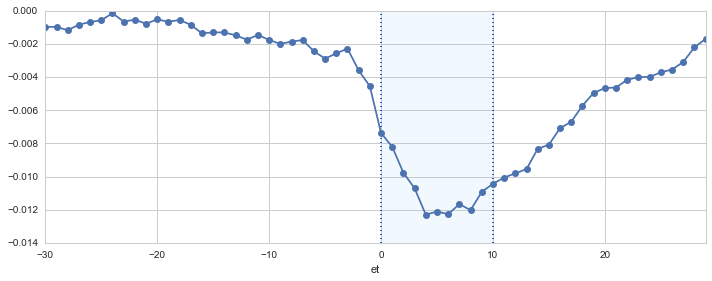

In [39]:
_ = plt.axvline(0 , linestyle=':', color=sns.xkcd_rgb["blue"] )
_ = plt.axvline(10, linestyle=':', color=sns.xkcd_rgb["blue"] )
_ = plt.axvspan(0 , 10, color=sns.xkcd_rgb["lightblue"], alpha=0.1, lw=0)

y = fire_rets[fire_rets['et'].isin(range(-30,30))]  

_ = y.groupby('et')['dgtw_xret'].mean().cumsum().plot( marker='o', figsize=(10,4) )
plt.tight_layout()

<br/><br/>

# Export

In [40]:
temp = fire.reset_index().sort_index()\
.groupby(['permno', 'ManagerCode', t])[['seq', 'DVol', 'vol_ratio']].first()\
.sort_values(by='DVol' )

temp.to_csv('Fire_sales_2.csv')

In [42]:
temp.describe()

,seq,DVol,vol_ratio
count,18598.000000,18598.000000,18598.000000
mean,155.233785,-5.846796,-0.826703
std,84.210745,47.059254,3.785412
min,2.010000,-5801.330009,-438.820004
25%,87.160000,-4.089111,-0.728758
50%,158.020000,-1.131027,-0.461053
75%,216.080000,-0.307159,-0.341406
max,340.040000,-0.001485,-0.272130


<br/><br/>